<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/CV_Gan/gan_hw_uncond_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500

### Создаем dataloader

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist",
                                          train=True,
                                          transform=torchvision.transforms.ToTensor(),
                                          download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15265855.89it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271547.30it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5035736.59it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19540522.16it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [ ]:
image, label = next(iter(dataloader))
image.size(), label

(torch.Size([16, 1, 28, 28]),
 tensor([7, 6, 6, 6, 0, 5, 6, 8, 8, 8, 1, 6, 8, 7, 5, 6]))

### Создаем модель GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

### Оптимизатор и функция потерь

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).to(DEVICE))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).to(DEVICE).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size).to(DEVICE))
real_label = 1
fake_label = 0

### GAN обучение

In [ ]:
IMG_ROWS,IMG_COLS = 28, 28

def plot_gen_images(gen_tensor, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(7,7))
    for i in range(gen_tensor.shape[0]):
        gen_img = gen_tensor[i].detach().cpu().numpy()
        ax[i//4, i%4].imshow(gen_img.reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
    plt.show()

Epoch:1 Iter: 500 errD_x: 0.15 errD_z: 0.07 errG: 2.81
Epoch:1 Iter: 1000 errD_x: 0.22 errD_z: 0.17 errG: 2.27
Epoch:1 Iter: 1500 errD_x: 0.13 errD_z: 0.19 errG: 2.44
Epoch:1 Iter: 2000 errD_x: 0.19 errD_z: 0.09 errG: 3.08
Epoch:1 Iter: 2500 errD_x: 0.33 errD_z: 0.07 errG: 2.94
Epoch:1 Iter: 3000 errD_x: 0.03 errD_z: 0.09 errG: 3.53
Epoch:1 Iter: 3500 errD_x: 0.04 errD_z: 0.02 errG: 4.98


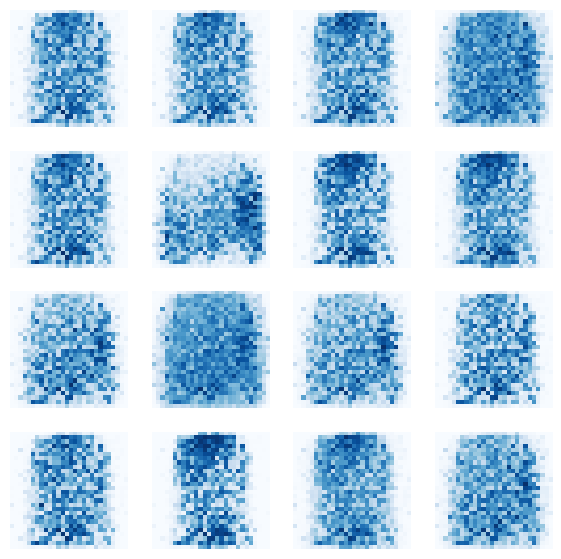

Epoch:2 Iter: 500 errD_x: 0.37 errD_z: 0.08 errG: 2.65
Epoch:2 Iter: 1000 errD_x: 0.29 errD_z: 0.07 errG: 2.89
Epoch:2 Iter: 1500 errD_x: 0.08 errD_z: 0.10 errG: 2.91
Epoch:2 Iter: 2000 errD_x: 0.29 errD_z: 0.14 errG: 2.55
Epoch:2 Iter: 2500 errD_x: 0.41 errD_z: 0.38 errG: 1.56
Epoch:2 Iter: 3000 errD_x: 0.42 errD_z: 0.05 errG: 3.07
Epoch:2 Iter: 3500 errD_x: 0.19 errD_z: 0.09 errG: 3.31


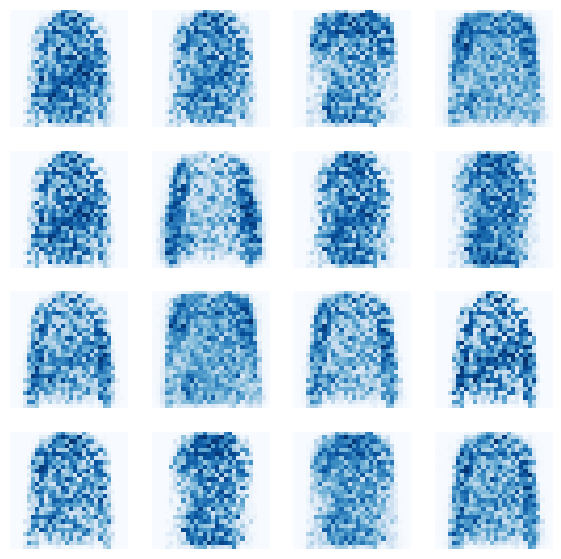

Epoch:3 Iter: 500 errD_x: 0.40 errD_z: 0.54 errG: 1.69
Epoch:3 Iter: 1000 errD_x: 0.12 errD_z: 0.23 errG: 2.38
Epoch:3 Iter: 1500 errD_x: 0.10 errD_z: 0.10 errG: 2.90
Epoch:3 Iter: 2000 errD_x: 0.19 errD_z: 0.23 errG: 1.72
Epoch:3 Iter: 2500 errD_x: 0.46 errD_z: 0.06 errG: 2.94
Epoch:3 Iter: 3000 errD_x: 0.27 errD_z: 0.12 errG: 2.19
Epoch:3 Iter: 3500 errD_x: 0.05 errD_z: 0.42 errG: 1.56


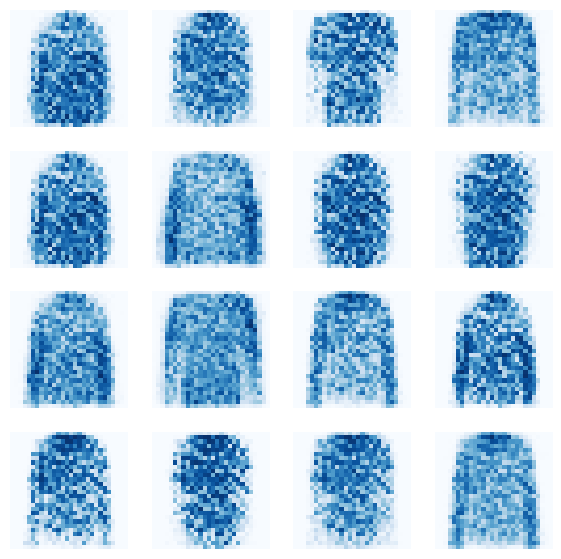

Epoch:4 Iter: 500 errD_x: 0.08 errD_z: 0.06 errG: 3.21
Epoch:4 Iter: 1000 errD_x: 0.08 errD_z: 0.29 errG: 2.04
Epoch:4 Iter: 1500 errD_x: 0.19 errD_z: 0.18 errG: 2.93
Epoch:4 Iter: 2000 errD_x: 0.37 errD_z: 0.09 errG: 3.47
Epoch:4 Iter: 2500 errD_x: 0.07 errD_z: 0.11 errG: 3.14
Epoch:4 Iter: 3000 errD_x: 0.22 errD_z: 0.19 errG: 1.98
Epoch:4 Iter: 3500 errD_x: 0.50 errD_z: 0.04 errG: 3.30


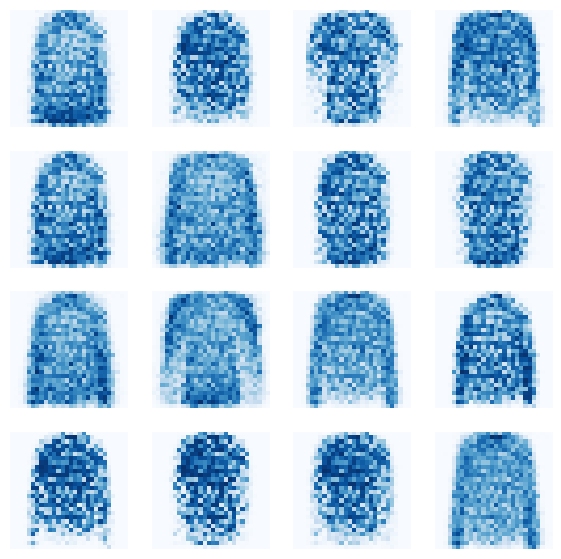

Epoch:5 Iter: 500 errD_x: 0.28 errD_z: 0.14 errG: 2.49
Epoch:5 Iter: 1000 errD_x: 0.51 errD_z: 0.11 errG: 2.69
Epoch:5 Iter: 1500 errD_x: 0.16 errD_z: 0.11 errG: 3.34
Epoch:5 Iter: 2000 errD_x: 0.01 errD_z: 0.32 errG: 2.76
Epoch:5 Iter: 2500 errD_x: 0.07 errD_z: 0.30 errG: 2.00
Epoch:5 Iter: 3000 errD_x: 0.61 errD_z: 0.05 errG: 4.11
Epoch:5 Iter: 3500 errD_x: 0.24 errD_z: 0.03 errG: 3.69


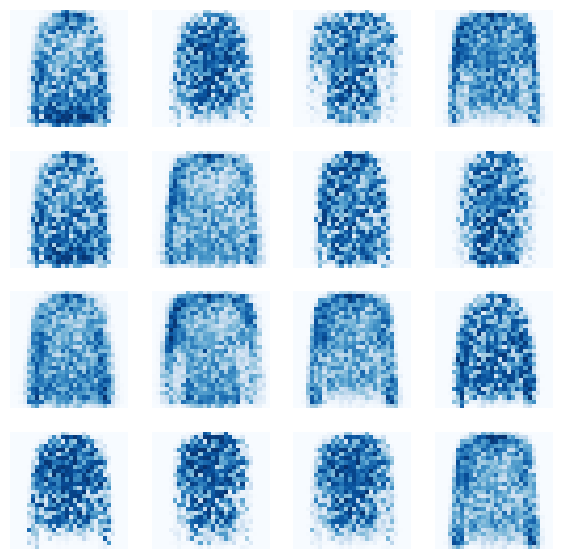

Epoch:6 Iter: 500 errD_x: 0.52 errD_z: 0.25 errG: 1.61
Epoch:6 Iter: 1000 errD_x: 0.23 errD_z: 0.11 errG: 2.18
Epoch:6 Iter: 1500 errD_x: 0.36 errD_z: 0.03 errG: 4.06
Epoch:6 Iter: 2000 errD_x: 0.36 errD_z: 0.10 errG: 3.14
Epoch:6 Iter: 2500 errD_x: 0.03 errD_z: 0.17 errG: 2.91
Epoch:6 Iter: 3000 errD_x: 0.24 errD_z: 0.19 errG: 2.20
Epoch:6 Iter: 3500 errD_x: 0.02 errD_z: 0.31 errG: 2.47


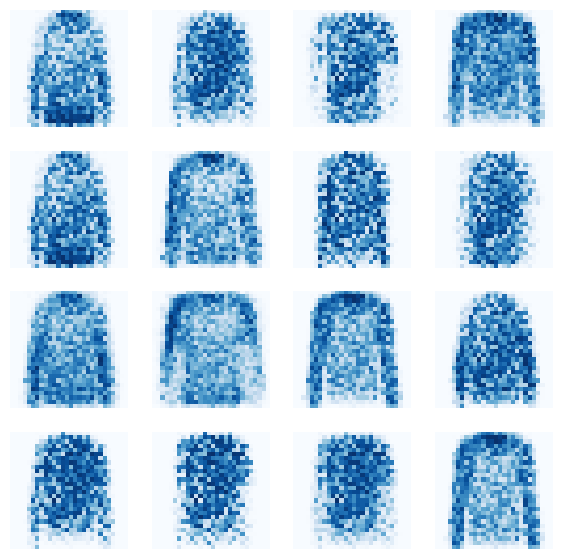

Epoch:7 Iter: 500 errD_x: 0.42 errD_z: 0.18 errG: 1.94
Epoch:7 Iter: 1000 errD_x: 0.31 errD_z: 0.09 errG: 3.39
Epoch:7 Iter: 1500 errD_x: 0.20 errD_z: 0.13 errG: 3.10
Epoch:7 Iter: 2000 errD_x: 0.21 errD_z: 0.12 errG: 2.68
Epoch:7 Iter: 2500 errD_x: 0.28 errD_z: 0.18 errG: 2.65
Epoch:7 Iter: 3000 errD_x: 1.24 errD_z: 0.14 errG: 2.34
Epoch:7 Iter: 3500 errD_x: 0.23 errD_z: 0.38 errG: 2.16


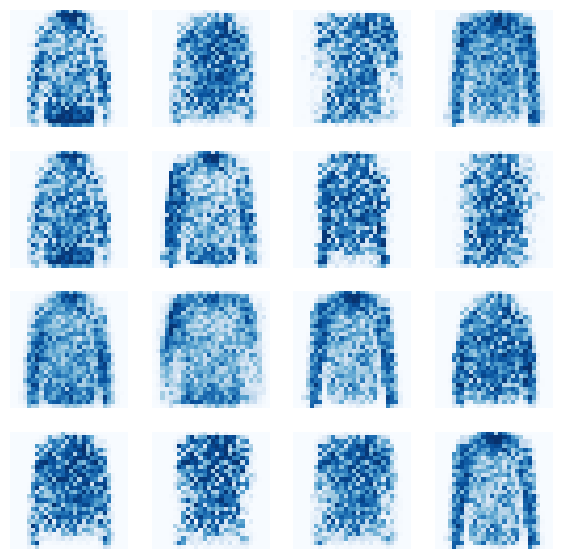

Epoch:8 Iter: 500 errD_x: 0.89 errD_z: 0.14 errG: 2.76
Epoch:8 Iter: 1000 errD_x: 0.58 errD_z: 0.06 errG: 3.26
Epoch:8 Iter: 1500 errD_x: 0.24 errD_z: 0.12 errG: 3.88
Epoch:8 Iter: 2000 errD_x: 0.58 errD_z: 0.17 errG: 2.28
Epoch:8 Iter: 2500 errD_x: 0.03 errD_z: 0.22 errG: 3.35
Epoch:8 Iter: 3000 errD_x: 0.49 errD_z: 0.20 errG: 2.58
Epoch:8 Iter: 3500 errD_x: 0.28 errD_z: 0.09 errG: 3.55


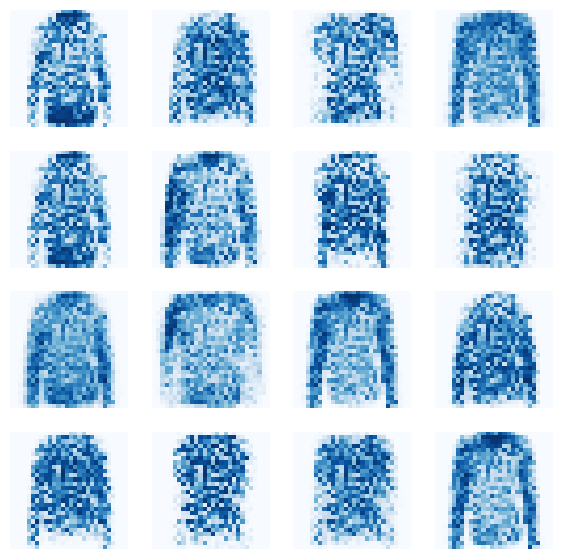

Epoch:9 Iter: 500 errD_x: 0.65 errD_z: 0.14 errG: 2.26
Epoch:9 Iter: 1000 errD_x: 0.16 errD_z: 0.33 errG: 1.61
Epoch:9 Iter: 1500 errD_x: 0.33 errD_z: 0.07 errG: 3.43
Epoch:9 Iter: 2000 errD_x: 0.11 errD_z: 0.35 errG: 2.11
Epoch:9 Iter: 2500 errD_x: 0.70 errD_z: 0.26 errG: 2.56
Epoch:9 Iter: 3000 errD_x: 1.18 errD_z: 0.23 errG: 1.86
Epoch:9 Iter: 3500 errD_x: 0.39 errD_z: 0.09 errG: 2.89


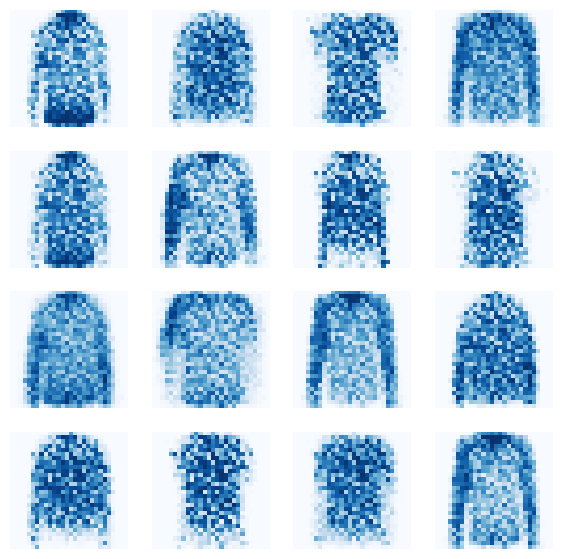

Epoch:10 Iter: 500 errD_x: 0.29 errD_z: 0.10 errG: 2.57
Epoch:10 Iter: 1000 errD_x: 0.39 errD_z: 0.26 errG: 1.47
Epoch:10 Iter: 1500 errD_x: 0.45 errD_z: 0.35 errG: 1.23
Epoch:10 Iter: 2000 errD_x: 0.30 errD_z: 0.11 errG: 3.14
Epoch:10 Iter: 2500 errD_x: 0.16 errD_z: 0.17 errG: 2.54
Epoch:10 Iter: 3000 errD_x: 0.32 errD_z: 0.16 errG: 2.51
Epoch:10 Iter: 3500 errD_x: 1.11 errD_z: 0.24 errG: 2.06


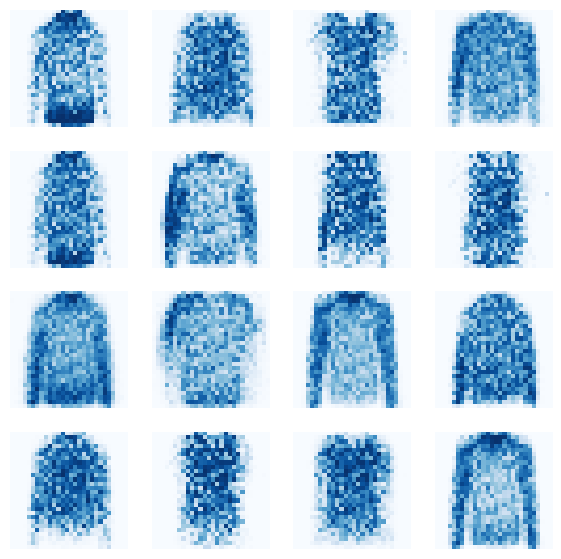

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        #discriminator.zero_grad()
        optim_D.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(DEVICE)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        #generator.zero_grad()
        optim_G.zero_grad()

        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item())
            )
        # Show result with fix_noise
        if iteration == N-1: plot_gen_images(generator(fixed_noise))

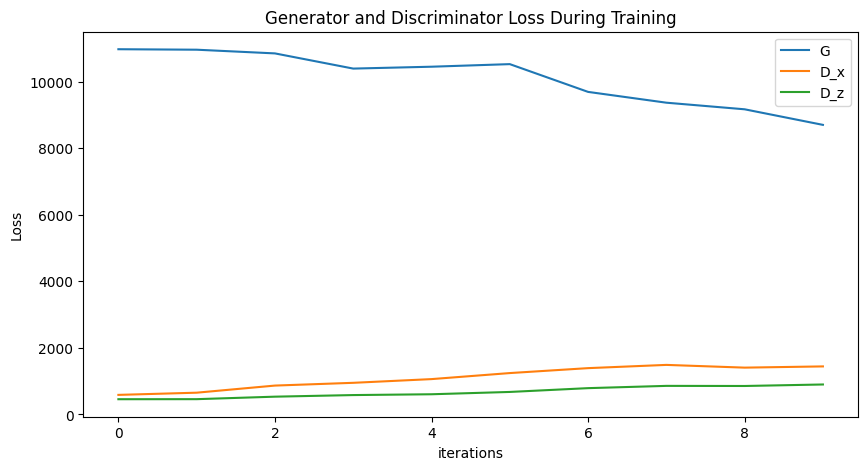

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(ERRG,label="G")
plt.plot(ERRD_x,label="D_x")
plt.plot(ERRD_z,label="D_z")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()